# Generative Model (NIR tablets dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


In [2]:
# import local utility functions
import sys
sys.path.append('../utils')
import utils as utl

## Load raw data and plot

In [3]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/tablets/NIR_tablets.csv')
data.head(5)

,7398.337,7406.051,7413.766,7421.481,7429.195,7436.91,7444.624,7452.339,7460.053,7467.768,...,10461.02,10468.73,10476.45,10484.16,10491.88,10499.59,10507.3,content (% w/w),label,scale
0,1.314189,1.251776,1.191130,1.133382,1.080259,1.031387,0.986337,0.945453,0.907986,0.872446,...,-0.124510,-0.126171,-0.124901,-0.125070,-0.129110,-0.132152,-0.130857,5.479603,1,0
1,1.418517,1.354198,1.292556,1.233600,1.179345,1.129443,1.083619,1.041672,1.002716,0.966060,...,-0.059346,-0.060028,-0.058698,-0.060552,-0.066295,-0.069032,-0.066877,5.482797,1,0
2,1.599241,1.532634,1.469086,1.407317,1.350641,1.298261,1.249429,1.205471,1.165011,1.125740,...,0.012248,0.011139,0.012459,0.010324,0.004168,0.001039,0.003172,5.477778,1,0
3,1.339236,1.277382,1.217709,1.160600,1.108079,1.059867,1.015320,0.974589,0.936828,0.901571,...,-0.085780,-0.086316,-0.084981,-0.086594,-0.091895,-0.094733,-0.093018,5.384615,1,0
4,1.493325,1.429678,1.368466,1.309522,1.254920,1.204737,1.158200,1.115872,1.077138,1.040555,...,-0.009153,-0.010739,-0.009463,-0.011218,-0.016961,-0.019661,-0.017702,5.373134,1,0


In [4]:
# shuffle data rows
data = data.sample(frac=1, random_state=42)

1: blue
2: red
3: green
4: orange


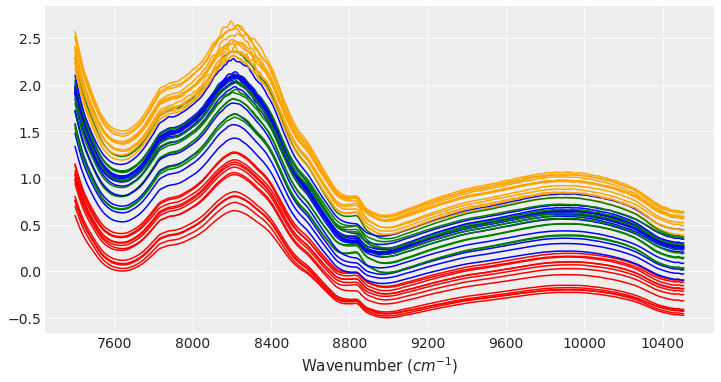

In [5]:
# name of column containing the labels
label_col = 'label'

# number of non-data columns at right of dataframe
non_data_cols = -3

# list of class labels
class_labels = utl.get_class_labels(data, label_col)

# plot dataframe
utl.plot_data(data, non_data_cols, label_col, 50)

In [6]:
#data.describe()

In [7]:
# number of samples from each class
data[label_col].value_counts()

4    80
3    80
2    80
1    70
Name: label, dtype: int64

In [8]:
# store the data values for all different classes
df = [data.query("label ==  @class_labels[@i]") for i in range(len(class_labels))]

x_n = data.columns[:non_data_cols]
x_s = [df[i][x_n].values for i in range(len(df))]

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a..d} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [9]:
with pm.Model() as model_gm:
    
    mu_m = pm.Lognormal('mu_m', mu=0, sigma=1) 
    sigma_ab = pm.Gamma('sigma_ab', alpha=1., beta=1.)
    sigma_mu = pm.HalfNormal('sigma_mu', sigma_ab)
    mu = pm.Normal('mu', mu=mu_m, sd=sigma_mu, shape=(len(class_labels),len(x_n)))
    
    sigma_s = pm.Gamma('sigma_s', alpha=1., beta=1.)
    sigma = pm.HalfNormal('sigma', sigma_s)
    
    class_a = pm.Normal('class_a', mu=mu[0], sd=sigma, observed=x_s[0][:len(x_s[0])])
    class_b = pm.Normal('class_b', mu=mu[1], sd=sigma, observed=x_s[1][:len(x_s[1])])
    class_c = pm.Normal('class_c', mu=mu[2], sd=sigma, observed=x_s[2][:len(x_s[2])])
    class_d = pm.Normal('class_d', mu=mu[3], sd=sigma, observed=x_s[3][:len(x_s[3])])
    
    trace_gm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
Sampling 2 chains: 100%|██████████| 5000/5000 [02:49<00:00, 29.56draws/s]


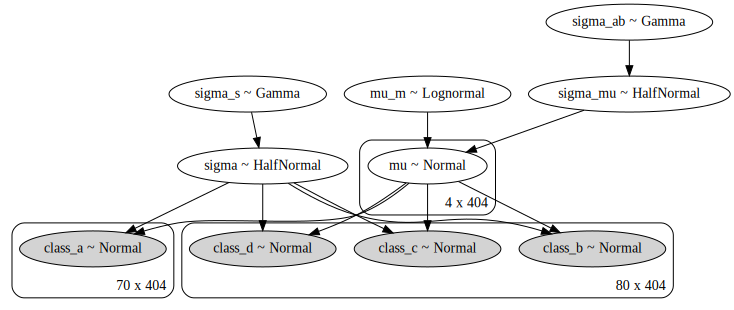

In [10]:
pm.model_to_graphviz(model_gm)

In [11]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",1.865,0.019,1.829,1.900,0.000,0.000,6714.0,6714.0,6703.0,2887.0,1.0
"mu[0,1]",1.792,0.018,1.759,1.830,0.000,0.000,6044.0,6023.0,6103.0,2349.0,1.0
"mu[0,2]",1.722,0.018,1.689,1.758,0.000,0.000,6230.0,6227.0,6214.0,2801.0,1.0
"mu[0,3]",1.654,0.019,1.618,1.690,0.000,0.000,6960.0,6960.0,6937.0,2845.0,1.0
"mu[0,4]",1.592,0.019,1.556,1.628,0.000,0.000,6320.0,6320.0,6306.0,2740.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,0.692,0.017,0.660,0.723,0.000,0.000,7006.0,6994.0,7020.0,2382.0,1.0
sigma_ab,1.059,0.746,0.222,2.427,0.012,0.009,4035.0,3317.0,6310.0,3057.0,1.0
sigma_mu,0.654,0.012,0.633,0.676,0.000,0.000,7262.0,7262.0,7224.0,2579.0,1.0
sigma_s,0.547,0.556,0.053,1.570,0.009,0.007,3806.0,3451.0,5492.0,3101.0,1.0


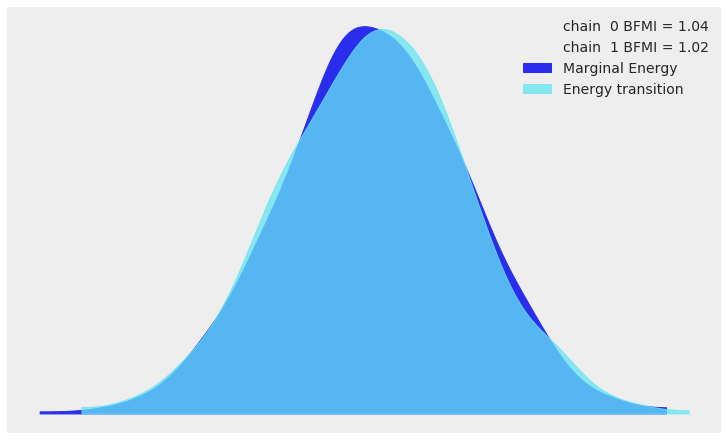

In [12]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [13]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=model_gm)

100%|██████████| 250/250 [00:03<00:00, 69.58it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


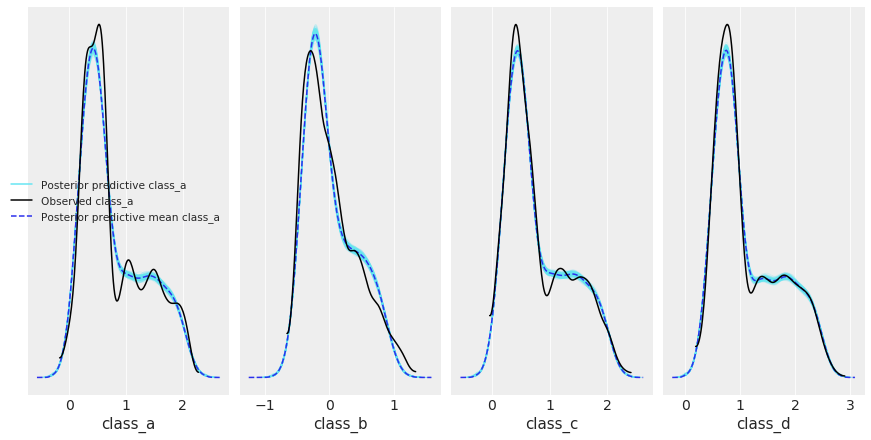

In [14]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [15]:
print(az.r2_score(x_s[0][:len(x_s[0])], ppc['class_a']))

r2        0.922444
r2_std    0.006400
dtype: float64


In [16]:
print(az.r2_score(x_s[1][:len(x_s[1])], ppc['class_b']))

r2        0.846928
r2_std    0.011673
dtype: float64


In [17]:
print(az.r2_score(x_s[2][:len(x_s[2])], ppc['class_c']))

r2        0.918369
r2_std    0.006720
dtype: float64


In [18]:
print(az.r2_score(x_s[3][:len(x_s[3])], ppc['class_d']))

r2        0.932643
r2_std    0.005596
dtype: float64


In [19]:
print(az.bfmi(trace_gm))

[1.0366621  1.01759906]


# Posterior samples vs. mean data

In [20]:
# class samples from the posterior
cl_a = ppc['class_a']
cl_b = ppc['class_b']
cl_c = ppc['class_c']
cl_d = ppc['class_d']

ppc_class_lst = [cl_a, cl_b, cl_c, cl_d]

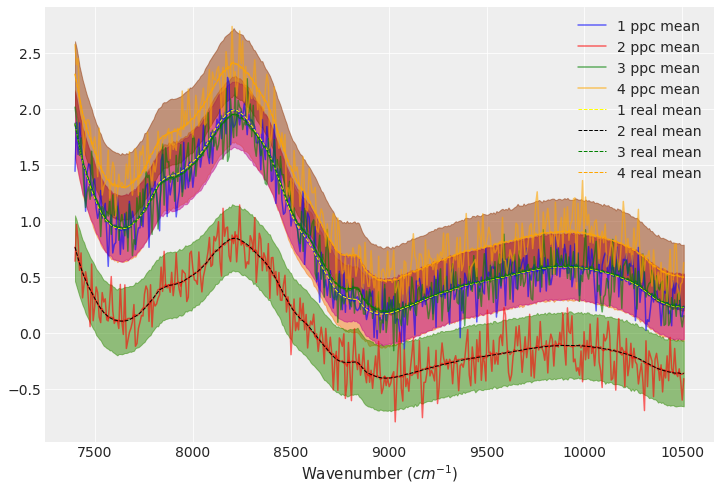

In [21]:
utl.plot_mean_vs_ppc(data, ppc_class_lst, non_data_cols, label_col)

# Real spectrum vs. posterior samples

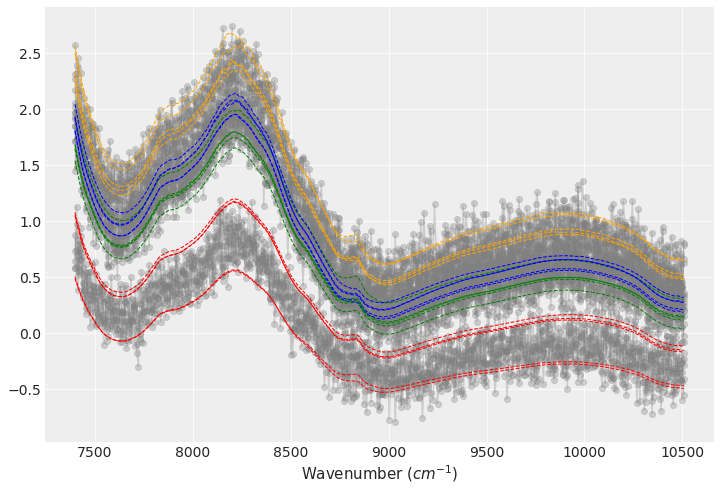

In [22]:
utl.plot_real_vs_ppc(data, ppc_class_lst, non_data_cols, label_col, 5)

# Save posterior samples to .csv file

In [23]:
x_val = utl.get_data_x_value_header(data, non_data_cols)
samples_per_class = 50
filename = './ppc_samples_nir_tablets.csv' 

utl.save_traces(filename, samples_per_class, x_val, class_labels, ppc_class_lst)